In [292]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import svm
from datetime import datetime
from sklearn import preprocessing
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from src.helpers.jobSap.jobSapHelpers import get_data_frame_from_text_job_file
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 01 - Importando Arquivos

In [268]:
def transform_to_datetime(date_str : str, format : str) -> datetime:
    return pd.to_datetime(date_str, format=format)
    
def transform_to_float(value):
    try:
        if ',' in value or '.' in value:
            numberStr = value.replace('.', '')
            numberStr = numberStr.replace(',', '.')
            number = float(numberStr)
            return number
    except:
        return float(0)

In [304]:
vl10g = 'm.csv'
data_frame = pd.read_csv(vl10g)

C:\Users\hilarion\AppData\Local\Temp\1\ipykernel_16460\3277191752.py:2: DtypeWarning: Columns (30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frame = pd.read_csv(vl10g)


## 02 - Transformando dados

In [ ]:
data_frame['Dt.carreg.'] = pd.to_datetime(data_frame['Dt.carreg.'], dayfirst = True)
data_frame['DtMinForn'] = pd.to_datetime(data_frame['DtMinForn'], dayfirst = True)
data_frame['DtPrepMat.'] = pd.to_datetime(data_frame['DtPrepMat.'], dayfirst = True)
data_frame['Data extracao'] = pd.to_datetime(data_frame['Data extracao'], dayfirst = True)

### Renomeando colunas

In [ ]:
data_frame = data_frame.rename(columns={'Qtd.conf.': 'quantidade_confirmada', 'Cen.': 'centro', 'Ds.Bloq.R' : 'BloqueioRemessa', 'Descricao Representante' : 'DescricaoRepresentante', 'Descricao Cliente/Fornecedor' : 'DescricaoClienteFornecedor', 'Motivo da Alteracao':'MotivoAlteracao', 'Repres. Principal':'Representante', 'Categoria' : 'CategoriaCliente'})

In [ ]:
data_frame['Origem'] = data_frame['Origem'].apply(str)
data_frame['Item'] = data_frame['Item'].apply(str)
data_frame['Material'] = data_frame['Material'].apply(str)
data_frame['centro'] = data_frame['centro'].apply(str)
data_frame['OrgV'] = data_frame['OrgV'].apply(str)
data_frame['CDst'] = data_frame['CDst'].apply(str)
data_frame['OrgV'] = data_frame['OrgV'].apply(str)

In [ ]:
data_frame = data_frame.drop('Unnamed: 0', axis=1)
data_frame = data_frame.drop('Unnamed: 0.1', axis=1)
data_frame = data_frame.drop('Desc. Coordenador de Vendas', axis=1)
data_frame = data_frame.drop('DescricaoRepresentante', axis=1)
data_frame = data_frame.drop('DescricaoClienteFornecedor', axis=1)
data_frame = data_frame.drop('Ag.frete', axis=1)
data_frame = data_frame.drop('DtMinForn', axis=1)

## 03 - Explorando dados

In [ ]:
data_frame.isna().sum()

Origem                        0
Item                          0
Material                      0
Denominacao                  54
quantidade_confirmada         0
QtDispOVPC                    0
EstqDispon                    0
ValorFatur                   15
Dt.carreg.                    6
CPgt                          0
Desc.Cond.Pagamento           2
centro                        0
OrgV                          0
Desc.Equipe Vendas           52
TpDV                          0
LExp                          6
Moeda                         0
CDst                          0
IncTm                         0
Bruto                         0
DtPrepMat.                    6
StatCredOV                  599
Data extracao                 0
MotivoAlteracao          923042
BloqueioRemessa          998759
HiC2                     768592
Representante            105041
Cliente                  105041
tempo_aberto             119474
CategoriaCliente         119474
dtype: int64

In [ ]:
data_frame.Item.value_counts()

10      368365
20      130536
30       80338
40       58775
50       43347
         ...  
3080         1
2540         1
2560         1
84           1
3040         1
Name: Item, Length: 383, dtype: int64

In [ ]:
data_frame.centro.value_counts()

1100    731390
1106    231783
1109     43676
1108     35723
1700      5550
Name: centro, dtype: int64

In [ ]:
data_frame.StatCredOV.value_counts()

Operacao OK          663698
Operacao nao OK      243407
Operacao nao Ok       99458
Operacao liberada     40813
Nao executada           147
Name: StatCredOV, dtype: int64

In [ ]:
data_frame.BloqueioRemessa.value_counts()

Fat. cfme. Obs.Coml.    19568
Fat.cfme.Coord.         16323
Fat.cfme.Cliente         4147
Fornec. completo         3126
Fat. Inspecao            2059
Fat.cfme.Repres.         1947
Fornec. Parcial          1174
Fat.via Cartao BNDES      337
Dados embarque            302
Bloq. Drawback Nac        194
Fat.Inspec.-Obs.Coml       83
Limite de credito          48
Fat.Finame                 46
WIT - Bloq. Embarque        9
Name: BloqueioRemessa, dtype: int64

In [ ]:
# Vimos a necessidade de substituir valores nulos por "Sem bloqueio", pois apenas as OV's que são consideradas problematicas são demarcadas.

data_frame['BloqueioRemessa'].fillna('Sem bloqueio', inplace=True)

In [ ]:
data_frame.CDst.value_counts()

20    806709
10    167159
30     74254
Name: CDst, dtype: int64

In [ ]:
data_frame.CPgt.value_counts()

V000    168154
V060    153330
VP21     76676
V028     71729
VP77     36610
         ...  
VC32         1
C000         1
VC52         1
VC94         1
VP66         1
Name: CPgt, Length: 275, dtype: int64

In [ ]:
data_frame.TpDV.value_counts()

ZVNO    1020471
ZVRC      27651
Name: TpDV, dtype: int64

In [ ]:
data_frame.OrgV.value_counts()

1001    731390
1009    231783
1019     79399
1004      5550
Name: OrgV, dtype: int64

In [ ]:
data_frame.Material.value_counts()

13884861    8272
14421152    6424
14639569    4715
11417378    4192
14595790    4182
            ... 
16366995       1
16252943       1
16388262       1
16306978       1
16672467       1
Name: Material, Length: 35943, dtype: int64

In [ ]:
data_frame.MotivoAlteracao.value_counts()

CLIENTE                 80295
ANTECIPADO              24344
LIMITE EXECIDO           9047
DUPLICATA VENCIDA        4008
FORNECIMENTO COMPLET     2915
ANALISE DE PORTFOLIO     2375
PRODUCAO                 1757
LIMITE EXCEDIDO           156
INSPECAO PRESENCIAL        96
PROJETO                    70
LOGISTICA                  17
Name: MotivoAlteracao, dtype: int64

In [ ]:
data_frame.CategoriaCliente.value_counts()

C    802001
B     92844
A     33803
Name: CategoriaCliente, dtype: int64

In [ ]:
# Vimos a necessidade de substituir valores nulos por "Sem alteracao", pois apenas as OV's que foram alteradas possuem esse motivo.

data_frame['MotivoAlteracao'].fillna('Sem alteracao', inplace=True)

In [ ]:
data_frame.Moeda.value_counts()

BRL    1048122
Name: Moeda, dtype: int64

In [ ]:
data_frame.describe()

,quantidade_confirmada,QtDispOVPC,EstqDispon,ValorFatur,Cliente,tempo_aberto
count,1.048122e+06,1.048122e+06,1.048122e+06,1.048107e+06,943081.000000,928648.000000
mean,6.861267e+01,5.876312e+01,3.719559e+02,1.777923e+04,441383.292857,50.737803
std,3.724411e+02,3.120629e+02,2.123022e+03,4.239938e+04,368143.249517,40.175361
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000,0.000000
25%,1.000000e+00,1.000000e+00,2.000000e+00,2.326510e+03,55590.000000,16.370829
50%,3.000000e+00,3.000000e+00,1.300000e+01,6.172010e+03,421219.000000,42.518282
75%,2.000000e+01,2.000000e+01,7.300000e+01,1.673926e+04,829422.000000,82.529121
max,1.411200e+04,1.411200e+04,7.938000e+04,1.323000e+06,976209.000000,223.127407


### Vimos a necessidade de extrair o mes previsto de faturamento, pois foi a melhor forma para identificarmos qual mes em que a ordem deveria ser faturada, já que se utilizassemos a data normal, iriam haver inumeras variaveis.

In [ ]:
data_frame['MesPrevisto'] = data_frame['Dt.carreg.'].dt.month

### Removendo linhas com o valor "Cliente" ausente

In [ ]:
data_frame = data_frame[~data_frame['Cliente'].isna()]
data_frame = data_frame[~data_frame['CategoriaCliente'].isna()]
data_frame = data_frame[~data_frame['StatCredOV'].isna()]

In [ ]:
data_frame.isna().sum()

Origem                        0
Item                          0
Material                      0
Denominacao                   0
quantidade_confirmada         0
QtDispOVPC                    0
EstqDispon                    0
ValorFatur                    9
Dt.carreg.                    2
CPgt                          0
Desc.Cond.Pagamento           2
centro                        0
OrgV                          0
Desc.Equipe Vendas           13
TpDV                          0
LExp                          6
Moeda                         0
CDst                          0
IncTm                         0
Bruto                         0
DtPrepMat.                    2
StatCredOV                    0
Data extracao                 0
MotivoAlteracao               0
BloqueioRemessa               0
HiC2                     704111
Representante                 0
Cliente                       0
tempo_aberto                  0
CategoriaCliente              0
MesPrevisto                   2
dtype: i

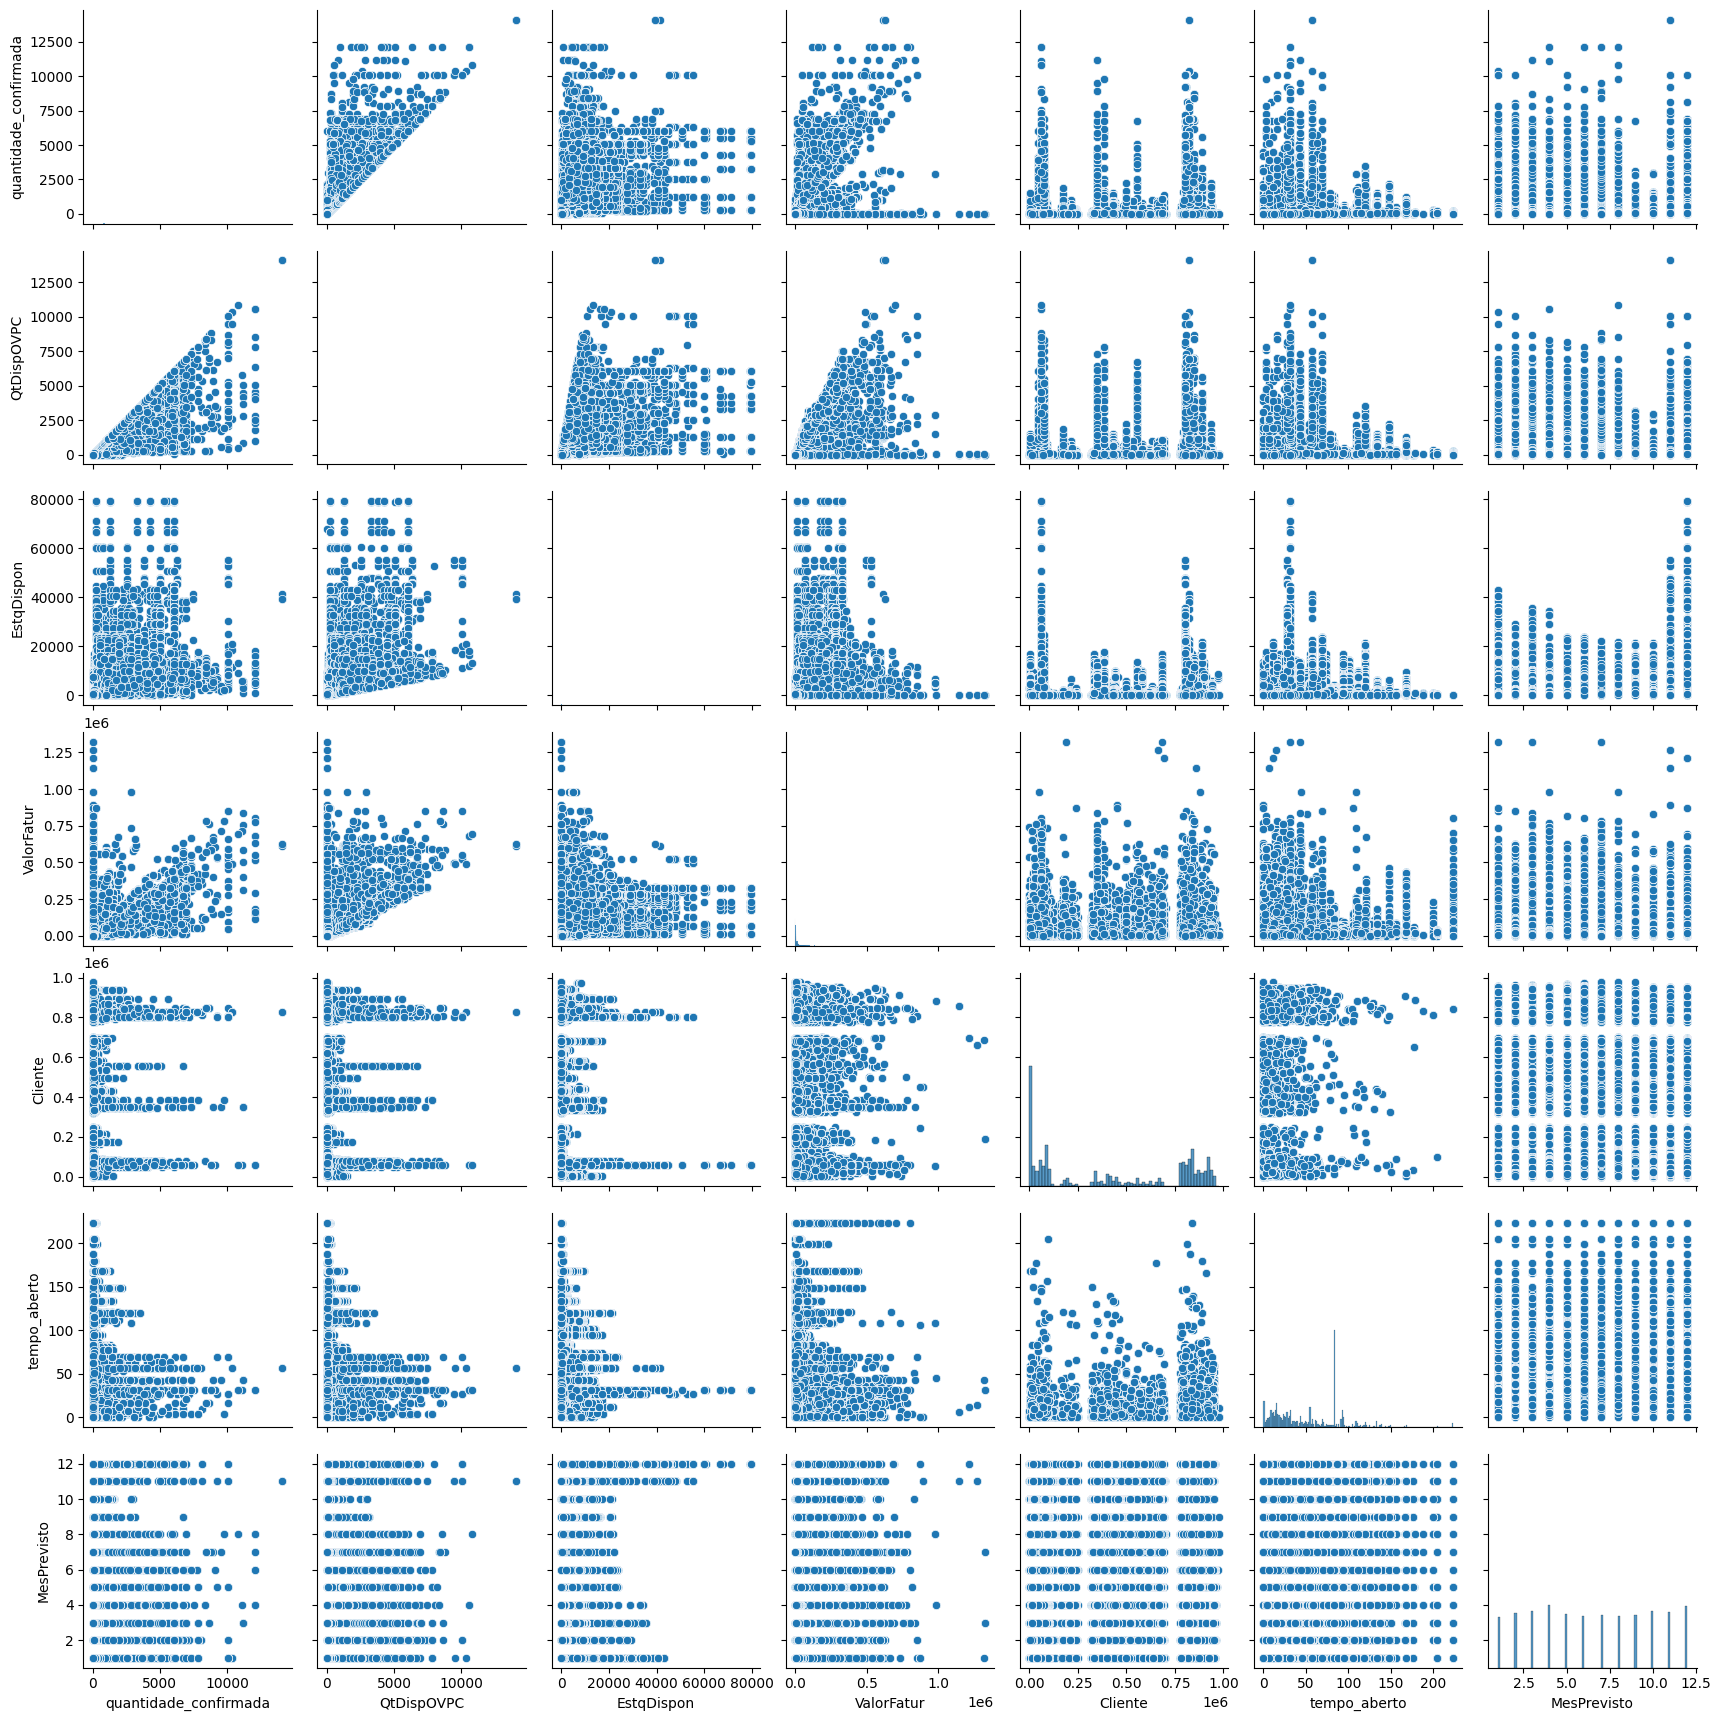

In [ ]:
sns.pairplot(data_frame)

In [ ]:
data_frame = data_frame.dropna()

## 04 - Pré-Processamento dos dados

### Transformando variaveis texto em numéricas (Encoder)

In [274]:
label_encoder = preprocessing.LabelEncoder()

data_frame['CategoriaCliente'] = label_encoder.fit_transform(data_frame['CategoriaCliente'])
data_frame['CPgt'] = label_encoder.fit_transform(data_frame['CPgt'])
data_frame['TpDV'] = label_encoder.fit_transform(data_frame['TpDV'])
data_frame['LExp'] = label_encoder.fit_transform(data_frame['LExp'])
data_frame['IncTm'] = label_encoder.fit_transform(data_frame['IncTm'])
data_frame['StatCredOV'] = label_encoder.fit_transform(data_frame['StatCredOV'])
data_frame['BloqueioRemessa'] = label_encoder.fit_transform(data_frame['BloqueioRemessa'])
data_frame['MotivoAlteracao'] = label_encoder.fit_transform(data_frame['MotivoAlteracao'])
data_frame['MesPrevisto'] = label_encoder.fit_transform(data_frame['MesPrevisto'])

C:\Users\hilarion\AppData\Local\Temp\1\ipykernel_16460\1271325680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['CategoriaCliente'] = label_encoder.fit_transform(data_frame['CategoriaCliente'])
C:\Users\hilarion\AppData\Local\Temp\1\ipykernel_16460\1271325680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['CPgt'] = label_encoder.fit_transform(data_frame['CPgt'])
C:\Users\hilarion\AppData\Local\Temp\1\ipykernel_16460\1271325680.py:5: SettingWithCopyWarning: 
A value is trying

### Separando os dados de entrada (x) e saída (y)

In [275]:
df1 = data_frame.loc[(data_frame['Data extracao'] < '01/01/22 00:00:00,000000000')]

### Dados de treino

In [276]:
x = df1[['CategoriaCliente', 'Item', 'CPgt', 'centro', 'LExp', 'IncTm', 'StatCredOV', 'BloqueioRemessa', 'MotivoAlteracao', 'MesPrevisto']]
y = df1['tempo_aberto']

# utilizado no catboost
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=7)
categorical_features_indices = np.where(x.dtypes !=float)[0]

In [277]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12503 entries, 421192 to 852087
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CategoriaCliente  12503 non-null  int64 
 1   Item              12503 non-null  object
 2   CPgt              12503 non-null  int64 
 3   centro            12503 non-null  object
 4   LExp              12503 non-null  int64 
 5   IncTm             12503 non-null  int64 
 6   StatCredOV        12503 non-null  int64 
 7   BloqueioRemessa   12503 non-null  int64 
 8   MotivoAlteracao   12503 non-null  int64 
 9   MesPrevisto       12503 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 1.0+ MB


## 4.1 - Criando modelo

### Linear Regression

In [297]:
# Criando o modelo de regressão linear
linear_regressor = LinearRegression()

# Treinando o modelo
linear_regressor.fit(x_train, y_train)
predict_train = linear_regressor.predict(x_train)

# Validando resultado
print(f'RMSE: {mean_squared_error(y_train, predict_train)**(0.5)}')
print(f'MAE: {mean_absolute_error(y_train, predict_train)}')

RMSE: 17.137516948848756
MAE: 10.756057219250456


#### CatBoost Regressor

In [298]:
# Criando o modelo do SVM
catboost = CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')

# Treinando o modelo
catboost.fit(x_train, y_train)
predict_train = catboost.predict(x_train)

# Validando resultado
print(f'RMSE: {mean_squared_error(y_train, predict_train)**(0.5)}')
print(f'MAE: {mean_absolute_error(y_train, predict_train)}')

0:	learn: 21.1854840	total: 2.28ms	remaining: 112ms
1:	learn: 20.3418049	total: 4.14ms	remaining: 99.5ms
2:	learn: 19.6311784	total: 6.52ms	remaining: 102ms
3:	learn: 19.0353929	total: 8.14ms	remaining: 93.6ms
4:	learn: 18.5472102	total: 9.61ms	remaining: 86.5ms
5:	learn: 18.0638695	total: 11.1ms	remaining: 81.3ms
6:	learn: 17.7028347	total: 12.6ms	remaining: 77.5ms
7:	learn: 17.3921937	total: 14ms	remaining: 73.3ms
8:	learn: 17.1311872	total: 15.5ms	remaining: 70.5ms
9:	learn: 16.8697460	total: 17.1ms	remaining: 68.3ms
10:	learn: 16.6336348	total: 18.5ms	remaining: 65.6ms
11:	learn: 16.4738937	total: 20.4ms	remaining: 64.6ms
12:	learn: 16.2988962	total: 21.9ms	remaining: 62.3ms
13:	learn: 16.1863405	total: 23.3ms	remaining: 59.8ms
14:	learn: 16.0877571	total: 24.5ms	remaining: 57.1ms
15:	learn: 16.0063950	total: 25.7ms	remaining: 54.7ms
16:	learn: 15.9420647	total: 27ms	remaining: 52.5ms
17:	learn: 15.8082784	total: 28.6ms	remaining: 50.8ms
18:	learn: 15.7621823	total: 29.9ms	remainin

### Random Forest Regressor

In [299]:
# Criando o modelo de regressão linear
model_RFR = RandomForestRegressor(max_depth=10)

# Treinando o modelo 
model_RFR.fit(x_train, y_train)
predict_train = model_RFR.predict(x_train)

# Validando resultado
print(f'RMSE: {mean_squared_error(y_train, predict_train)**(0.5)}')
print(f'MAE: {mean_absolute_error(y_train, predict_train)}')


RMSE: 10.91765062940608
MAE: 5.241813521794854


## 5 - Validação

### Dados de validação

Separando o historico de um mês completo para realizar a predição com base no valor total mensal

In [284]:
df2 = data_frame.loc[(data_frame['Data extracao'] >= '01/01/22 00:00:00,000000000') & (data_frame['Data extracao'] <= '31/01/22 00:00:00,000000000')]

# Separando a base de teste
x = df2[['CategoriaCliente', 'Item', 'CPgt', 'centro', 'LExp', 'IncTm', 'StatCredOV', 'BloqueioRemessa', 'MotivoAlteracao', 'MesPrevisto']]
y = df2['tempo_aberto']

In [285]:
mean = df2['tempo_aberto'].mean()

### Linear Regressor

Calculando a RMSE do modelo Linear Regressor, utilizando o mês de janeiro de 2022, para realizar a previsão.

In [301]:
linearResult = linear_regressor.predict(x)
result = mean_squared_error(y, linearResult)**(0.5)
print(f'RMSE: {result}')
print(f'MAE: {mean_absolute_error(y, linearResult)}')

RMSE: 20.249963657680706
MAE: 12.02198345310502


### Catboost

Calculando a RMSE do modelo CatBoost Regressor

In [302]:
catboostResult = catboost.predict(x)
result = mean_squared_error(y, catboostResult)**(0.5)
print(f'RMSE: {result}')
print(f'MAE: {mean_absolute_error(y, catboostResult)}')

RMSE: 19.088441309428127
MAE: 10.17825039394118


### Random Forest Regressor

Calculando a RMSE do modelo Random Forest Regressor

In [303]:
rfrResult = model_RFR.predict(x)
result = mean_squared_error(y, rfrResult)**(0.5)
print(f'RMSE: {result}')
print(f'MAE: {mean_absolute_error(y, rfrResult)}')

RMSE: 16.799666876766786
MAE: 7.703558193501564


In [289]:
print(mean)

22.438905159102838


Link para o artigo, <a href='https://docs.google.com/document/d/1GZmr2Lvn5LtfPJV01HY7KZs22P0B329_/edit?usp=sharing&ouid=109647876324855359949&rtpof=true&sd=true'>clique aqui</a>